## Import necessary packages

In [2]:
import os

import keras.models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from math import sin, cos, pi

import tensorflow
from keras.applications.resnet import ResNet50
from keras.layers import Conv2D, LeakyReLU, GlobalAveragePooling2D, Dropout, Dense
from keras.models import Sequential



In [ ]:


newX = 96
newY = 96

def getNewValueAfterResize(coordinate, originalSize, newLength=newX):
    return int(newLength / int(originalSize) * int(coordinate))


def getNewValueAfterResizeAsString(coordinate, originalSize, newLength=newX):
    return str(int(newLength / int(originalSize) * int(coordinate)))


def writeTest():
    global newlines
    file1 = open('annotations_test.csv', 'r')
    lines = file1.readlines()
    newlines = [
        'left_acetabular_x,left_acetabular_y,left_femural_x,left_femural_y,right_acetabular_x,right_acetabular_y,right_femural_x,right_femural_y']
    for i in range(0, len(lines), 4):
        la = lines[i].split(",")
        lf = lines[i + 1].split(",")
        rf = lines[i + 2].split(",")
        ra = lines[i + 3].split(",")
        original_image_size_x=int(la[4])
        original_image_size_y=int(la[5])
        new_elem = getNewValueAfterResizeAsString(la[1],original_image_size_x) + ',' + getNewValueAfterResizeAsString(
            la[2],original_image_size_y) + ',' + getNewValueAfterResizeAsString(lf[1],original_image_size_x) + ',' + getNewValueAfterResizeAsString(lf[2],original_image_size_y) + ',' + \
                   getNewValueAfterResizeAsString(rf[1],original_image_size_x) + ',' + getNewValueAfterResizeAsString(
            rf[2], original_image_size_y) + ',' + getNewValueAfterResizeAsString(ra[1],original_image_size_x) + ',' + getNewValueAfterResizeAsString(ra[2],original_image_size_y)
        print(new_elem)
        newlines.append(new_elem)
    filetest = open("newAnnotationsTest2.csv", "w")
    newText = '\n'.join(newlines)
    filetest.write(newText)


def writeTraining():
    global newlines
    file1 = open('annotations_training.csv', 'r')
    lines = file1.readlines()
    newlines = [
        'left_acetabular_x,left_acetabular_y,left_femural_x,left_femural_y,right_acetabular_x,right_acetabular_y,right_femural_x,right_femural_y']
    for i in range(0, len(lines), 4):
        la = lines[i].split(",")
        lf = lines[i + 1].split(",")
        rf = lines[i + 2].split(",")
        ra = lines[i + 3].split(",")
        original_image_size_x = int(la[4])
        original_image_size_y = int(la[5])
        new_elem = getNewValueAfterResizeAsString(la[1], original_image_size_x) + ',' + getNewValueAfterResizeAsString(
            la[2], original_image_size_y) + ',' + getNewValueAfterResizeAsString(lf[1],
                                                                                 original_image_size_x) + ',' + getNewValueAfterResizeAsString(
            lf[2], original_image_size_y) + ',' + \
                   getNewValueAfterResizeAsString(rf[1], original_image_size_x) + ',' + getNewValueAfterResizeAsString(
            rf[2], original_image_size_y) + ',' + getNewValueAfterResizeAsString(ra[1], original_image_size_x) + ',' + getNewValueAfterResizeAsString(ra[2], original_image_size_y)
        print(new_elem)
        newlines.append(new_elem)
    filetest = open("newAnnotationsTraining2.csv", "w")
    newText = '\n'.join(newlines)
    filetest.write(newText)


print(os.listdir("test"))
print(os.listdir("training"))
training_annotations = pd.read_csv("annotations_training.csv")
test_annotations = pd.read_csv("annotations_test.csv")


In [8]:
def convertImage(img):
    color = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    resize = cv2.resize(color, dsize=(96, 96), interpolation=cv2.INTER_CUBIC)
    return np.reshape(resize, (96,96,1))

In [13]:
def plot_sample(image, keypoint, axis, title):
    image = image.reshape(96,96)
    axis.imshow(image, cmap='gray')
    axis.scatter(keypoint[0::2], keypoint[1::2], marker='x', s=20)
    plt.title(title)

## Loading Data


In [4]:
train_file = pd.read_csv('./newAnnotationsTraining.csv')
test_file = pd.read_csv('./newAnnotationsTest.csv')

In [78]:
train_file.head()

,left_acetabular_x,left_acetabular_y,left_femural_x,left_femural_y,right_acetabular_x,right_acetabular_y,right_femural_x,right_femural_y
0,33,53,34,57,53,56,54,52
1,32,31,34,36,62,36,64,32
2,34,37,33,40,61,41,60,37
3,34,49,36,54,64,57,66,53
4,30,39,30,45,56,45,57,40


In [79]:
test_file.head()


,left_acetabular_x,left_acetabular_y,left_femural_x,left_femural_y,right_acetabular_x,right_acetabular_y,right_femural_x,right_femural_y
0,31,34,33,39,57,36,58,32
1,30,34,30,38,59,40,61,37
2,36,60,37,64,61,64,62,61
3,35,34,37,38,63,36,63,31
4,34,24,32,27,59,28,60,24


## Load images and keypoints

In [9]:
def load_images(directory):
    images = []
    for f in sorted(os.listdir(directory)):
        images.append(convertImage(cv2.imread(os.path.join(directory,f))))
    images = np.array(images)/255.
    return images

def load_keypoints(keypoint_data):
    keypoint_data_csv = pd.read_csv(keypoint_data)
    keypoint_features = []
    for idx, features in keypoint_data_csv.iterrows():
        keypoint_features.append(features)
    keypoint_features = np.array(keypoint_features, dtype=int)
    return keypoint_features

train_images = load_images('./training')
images = load_images('./training')
train_keypoints = load_keypoints('newAnnotationsTraining.csv')
keypoints = load_keypoints('newAnnotationsTraining.csv')
test_images = load_images('./test')

## Augmentation

In [120]:
class aug_config:
    rotation_augmentation = True
    brightness_augmentation = True
    shift_augmentation = True
    random_noise_augmentation = True
    rotation_angles = [15]
    pixel_shifts = [15]

### Rotation

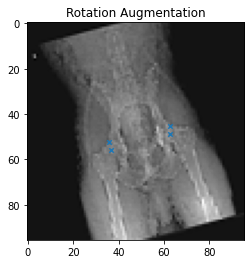

In [130]:
def rotate_augmentation(images, keypoints, rotation_angles):
    rotated_images = []
    rotated_keypoints = []
    for angle in rotation_angles:
        for angle in [angle, -angle]:
            M = cv2.getRotationMatrix2D((48,48), angle, 1.)
            angle_rad = -angle*pi/180.
            for image in images:
                rotated_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                rotated_images.append(rotated_image)
            for keypoint in keypoints:
                rotated_keypoint = keypoint - 48.
                for idx in range(0, len(rotated_keypoint), 2):
                    rotated_keypoint[idx] = rotated_keypoint[idx]*cos(angle_rad)-rotated_keypoint[idx+1]*sin(angle_rad)
                    rotated_keypoint[idx+1] = rotated_keypoint[idx]*sin(angle_rad)+rotated_keypoint[idx+1]*cos(angle_rad)
                rotated_keypoint += 48.
                rotated_keypoints.append(rotated_keypoint)

    return np.reshape(rotated_images,(-1,96,96,1)), rotated_keypoints

if aug_config.rotation_augmentation:
    rotated_train_images, rotated_train_keypoints = rotate_augmentation(images, keypoints, aug_config.rotation_angles)
    train_images = np.concatenate((train_images, rotated_train_images))
    train_keypoints = np.concatenate((train_keypoints, rotated_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(rotated_train_images[19], rotated_train_keypoints[19], axis, "Rotation Augmentation")

### Change Brightness

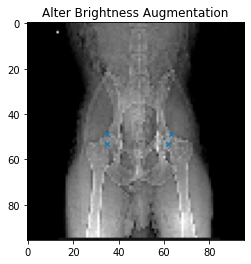

In [131]:
def alter_brightness(images, keypoints):
    altered_brightness_images = []
    inc_brightness_images = np.clip(images*1.2, 0.0, 1.0)
    dec_brightness_images = np.clip(images*0.6, 0.0, 1.0)
    altered_brightness_images.extend(inc_brightness_images)
    altered_brightness_images.extend(dec_brightness_images)
    return altered_brightness_images, np.concatenate((keypoints, keypoints))

if aug_config.brightness_augmentation:
    altered_brightness_images, altered_brightness_keypoints = alter_brightness(images, keypoints)
    train_images = np.concatenate((train_images, altered_brightness_images))
    train_keypoints = np.concatenate((train_keypoints, altered_brightness_keypoints))
    fig, axis = plt.subplots()
    plot_sample(altered_brightness_images[19], altered_brightness_keypoints[19], axis, "Alter Brightness Augmentation")

### Shift images

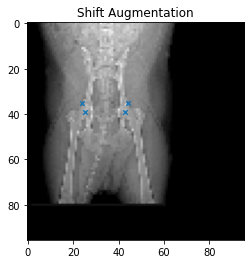

In [132]:
def shift_images(images, keypoints, pixel_shifts):
    shifted_images = []
    shifted_keypoints = []
    for shift in pixel_shifts:
        for (shift_x,shift_y) in [(-shift,-shift),(-shift,shift),(shift,-shift),(shift,shift)]:
            M = np.float32([[1,0,shift_x],[0,1,shift_y]])
            for image, keypoint in zip(images, keypoints):
                shifted_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                shifted_keypoint = np.array([(point+shift_x) if idx%2==0 else (point+shift_y) for idx, point in enumerate(keypoint)])
                if np.all(0.0<shifted_keypoint) and np.all(shifted_keypoint<96.0):
                    shifted_images.append(shifted_image.reshape(96,96,1))
                    shifted_keypoints.append(shifted_keypoint)
    shifted_keypoints = np.clip(shifted_keypoints,0.0,96.0)
    return shifted_images, shifted_keypoints

if aug_config.shift_augmentation:
    shifted_train_images, shifted_train_keypoints = shift_images(images, keypoints, aug_config.pixel_shifts)
    train_images = np.concatenate((train_images, shifted_train_images))
    train_keypoints = np.concatenate((train_keypoints, shifted_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(shifted_train_images[8], shifted_train_keypoints[8], axis, "Shift Augmentation")

### Add noise

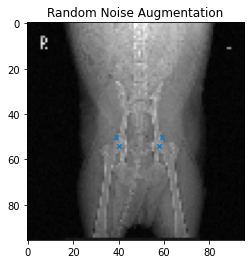

In [133]:
def add_noise(images):
    noisy_images = []
    for image in images:
        noisy_image = cv2.add(image, 0.008*np.random.randn(96,96,1))
        noisy_images.append(noisy_image.reshape(96,96,1))
    return noisy_images

if aug_config.random_noise_augmentation:
    noisy_train_images = add_noise(images)
    train_images = np.concatenate((train_images, noisy_train_images))
    train_keypoints = np.concatenate((train_keypoints, keypoints))
    fig, axis = plt.subplots()
    plot_sample(noisy_train_images[8], keypoints[8], axis, "Random Noise Augmentation")


## Modeling

In [21]:
import tensorflow as tf

model = Sequential()
pretrained_model = ResNet50(input_shape=(96,96,3), include_top=False, weights='imagenet')
pretrained_model.trainable = True

model.add(Conv2D(3, (1,1), padding='same', input_shape=(96,96,1)))
model.add(LeakyReLU(alpha=0.1))
model.add(pretrained_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.1))
model.add(Dense(8))
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 96, 96, 3)         6         
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 96, 96, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 8)                 16392     
                                                      

### Training the Model

In [139]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlyStopping = EarlyStopping(monitor='loss', patience=30, mode='min',
                             baseline=None)

rlp = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, min_lr=1e-15, mode='min', verbose=1)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

history = model.fit(train_images, train_keypoints, epochs=100, batch_size=16, validation_split=0.15, callbacks=[earlyStopping, rlp])


Epoch 1/200
22/22 [==============================] - 22s 799ms/step - loss: 712.5172 - accuracy: 0.3988 - val_loss: 557.1470 - val_accuracy: 0.5968 - lr: 0.0010

## Predicting on Test Set and Submission

[[30.792807 33.924297 31.672432 37.89128  57.667793 36.040627 57.814087
  31.553045]
 [31.937025 31.51963  32.674435 35.91133  59.03341  36.52769  59.42765
  31.582636]
 [36.11503  55.3843   37.236988 59.057262 58.059593 59.69387  59.5194
  56.056553]
 [34.036884 35.139774 35.064877 39.100967 62.522964 37.319256 62.68364
  33.441883]
 [31.352442 24.326416 31.597551 28.082253 58.399467 29.789728 59.880695
  26.034697]
 [32.196484 30.52848  33.337593 34.313534 60.900288 34.5844   61.787533
  30.473585]
 [34.857693 37.752945 35.807266 41.574806 58.470978 41.005703 59.144268
  37.01423 ]
 [34.327175 35.569706 34.758102 38.82663  57.967365 38.819492 58.078136
  35.081467]
 [35.940086 45.113255 36.612316 48.493347 60.52287  48.00895  61.628292
  44.708935]
 [34.17044  28.504469 35.178608 32.115532 59.201103 33.037945 60.335567
  29.25706 ]]


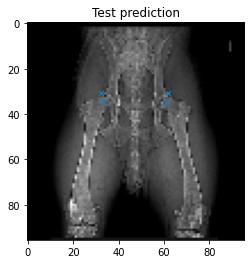

In [149]:
test_preds = model.predict(test_images)
print(test_preds)
fig, axis = plt.subplots()
plot_sample(test_images[5], test_preds[5], axis, "Test prediction")

In [153]:
print(model)
model.save("currentModel")

INFO:tensorflow:Assets written to: currentModel\assets


c:\users\ttibi\pycharmprojects\anglefinder\venv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\users\ttibi\pycharmprojects\anglefinder\venv\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: currentModel\assets


c:\users\ttibi\pycharmprojects\anglefinder\venv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\users\ttibi\pycharmprojects\anglefinder\venv\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: currentModel\assets


c:\users\ttibi\pycharmprojects\anglefinder\venv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\users\ttibi\pycharmprojects\anglefinder\venv\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: currentModel\assets


c:\users\ttibi\pycharmprojects\anglefinder\venv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\users\ttibi\pycharmprojects\anglefinder\venv\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [11]:
import keras
model2=keras.models.load_model("currentModel")
predict = model2.predict(test_images)
print(predict)

[[30.792807 33.924297 31.672432 37.89128  57.667793 36.040627 57.814087
  31.553045]
 [31.937025 31.51963  32.674435 35.91133  59.03341  36.52769  59.42765
  31.582636]
 [36.11503  55.3843   37.236988 59.057262 58.059593 59.69387  59.5194
  56.056553]
 [34.036884 35.139774 35.064877 39.100967 62.522964 37.319256 62.68364
  33.441883]
 [31.352442 24.326416 31.597551 28.082253 58.399467 29.789728 59.880695
  26.034697]
 [32.196484 30.52848  33.337593 34.313534 60.900288 34.5844   61.787533
  30.473585]
 [34.857693 37.752945 35.807266 41.574806 58.470978 41.005703 59.144268
  37.01423 ]
 [34.327175 35.569706 34.758102 38.82663  57.967365 38.819492 58.078136
  35.081467]
 [35.940086 45.113255 36.612316 48.493347 60.52287  48.00895  61.628292
  44.708935]
 [34.17044  28.504469 35.178608 32.115532 59.201103 33.037945 60.335567
  29.25706 ]]


TypeError: only integer scalar arrays can be converted to a scalar index

In [22]:
for i in range(10):
    fig, axis = plt.subplots()
    plot_sample(test_images[i], predict[i], axis, "Test prediction")

error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'polylines'
> Overload resolution failed:
>  - Can't parse 'pts'. Sequence item with index 0 has a wrong type
>  - Can't parse 'pts'. Sequence item with index 0 has a wrong type
